# Quantum Key Distribution - B92

Original code, which explained the BB84 protocol, sourced from: 

https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html

## Contents

1. Introduction
2. Protocol Overview
3. Qiskit Example

## 1. Introduction

When Alice and Bob want to communicate a secret message (such as Bob’s online banking details) over an insecure channel (such as the internet), its essential to encrypt the message. Since cryptography is a large area and almost all of it is outside the scope of this textbook, we will have to believe that Alice and Bob having a secret key that no-one else knows is useful and allows them to communicate using symmetric-key cryptography.

If Alice and Bob want to use Eve’s classical communication channel to share their key, it is impossible to tell if Eve has made a copy of this key for herself- they must place complete trust in Eve that she is not listening. If, however, Eve provides a quantum communication channel, Alice and Bob no longer need to trust Eve at all- they will know if she tries to read Bob’s message before it gets to Alice.

For some readers, it may be useful to give an idea of how a quantum channel may be physically implemented. An example of a classical channel could be a telephone line; we send electric signals through the line that represent our message (or bits). A proposed example of a quantum communication channel could be some kind of fibre-optic cable, through which we can send individual photons (particles of light). Photons have a property call _polarisation,_ and this polarisation can be one of two states. We can use this to represent a qubit.


## 2. Protocol Overview  

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it before Bob does, there is a chance that Eve’s measurement will change the state of the qubit and Bob will not receive the qubit state Alice sent.  

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint, choice
import numpy as np
print("Imports Successful")

Imports Successful


If Alice prepares a qubit in the state $|+\rangle$ (`0` in the X-basis), and Bob measures it in the X-basis, Bob is sure to measure `0`:

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c_0: ══════════════╩═

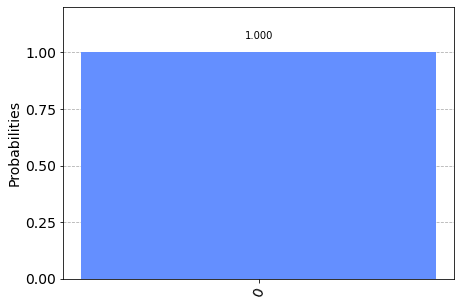

In [2]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

But if Eve tries to measure this qubit in the Z-basis before it reaches Bob, she will change the qubit's state from $|+\rangle$ to either $|0\rangle$ or $|1\rangle$, and Bob is no longer certain to measure `0`:

┌───┐┌─┐ ░ ┌───┐┌─┐
q_0: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c_0: ══════╩══════════╩═

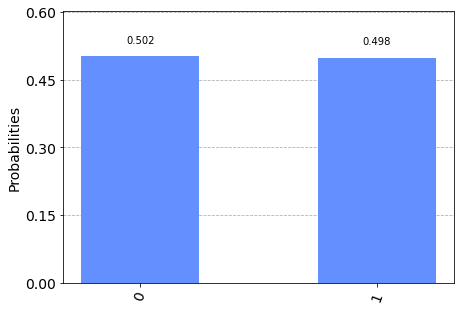

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

We can see here that Bob now has a 50% chance of measuring `1`, and if he does, he and Alice will know there is something wrong with their channel.

The B92 quantum key distribution protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception. It is roughly as follows:

**- Step 0**

It is assumed that Alice and Bob have agreed beforehand that the two basis sets along which they will be measuring qubits are the Binary basis set and the Hadamar basis set.

It is assumed that Bob knows that Alice is encoding her `1`s as `+`s and her `0`s as `0`s.

It is assumed that Alice and Bob have agreed beforehand on lengths of random strings to be generated, number of qubits to destroy in testing, etc.

In [4]:
qubits_count = 50
check_count = 3

**- Step 1a**

Alice chooses a string of random bits to be her secret key, e.g.:

In [5]:
alice_secret_key = ''.join([str(randint(0, 2)) for i in range(qubits_count)])
print("Alice's secret key is:", alice_secret_key)

Alice's secret key is: 10011011100000000010011010011000010001011001100110


Alice keeps this piece of information private to herself. 

**- Step 1b**

Alice then encodes her secret key and sends it to Bob. 
She encodes each 0 as a $|0\rangle$, and she encodes each 1 as a $|+\rangle$.

In this case, the string of encoded qubits would look like:

In [6]:
alice_encoded_qubits = alice_secret_key.replace("1", "+")
print("Alice's encoded qubits, sent to Bob, are:", alice_encoded_qubits)

Alice's encoded qubits, sent to Bob, are: +00++0+++000000000+00++0+00++0000+000+0++00++00++0


**- Step 2a**

Bob randomly selects between the Binary basis and the Hadamar basis as the basis with which he will measure each qubit that Alice sends him. Letting `B` represent the Binary basis and letting `H` represent Hadamar basis, he might use the bases:


In [7]:
bobs_chosen_bases = ''.join([choice(['B', 'H']) for i in range(qubits_count)])
print("Bob's chosen bases are:", bobs_chosen_bases)

Bob's chosen bases are: BHHBHHBBHBHHHHBBBBHHBBBHBBHBBBHBHBBHHHBBHBHHBBHBHH


Bob keeps his basis set choices private for now.

**- Step 2b**

Bob recieves Alice's qubits, measuring each qubit along the corresponding basis that he chose for it beforehand. 

In [8]:
bobs_measured_results = []
for i in range(qubits_count):
    sent_qubit = alice_encoded_qubits[i]
    chosen_basis = bobs_chosen_bases[i]
    if sent_qubit == '0' and chosen_basis == 'B':
        bobs_measured_results.append("0")
    elif sent_qubit == '0' and chosen_basis == 'H':
        if randint(0, 2):
            bobs_measured_results.append("+")
        else:
            bobs_measured_results.append("-")
    elif sent_qubit == '+' and chosen_basis == 'B':
        if randint(0, 2):
            bobs_measured_results.append("0")
        else:
            bobs_measured_results.append("1")
    elif sent_qubit == '+' and chosen_basis == 'H':
        bobs_measured_results.append("+")
bobs_measured_results = ''.join(bobs_measured_results)
print("Bob's measured results are:", bobs_measured_results)

Bob's measured results are: 0+-0+-01+0+-+-0000++001-10+000-0-00-++00+0-+00-0++


There are 4 equally likely permutations that might arise in each measurement:
- Alice sends a $|0\rangle$ which Bob measures in the Binary basis. 
    - With 100% certainty, Bob will measure a $|0\rangle$.
- Alice sends a $|0\rangle$ which Bob measures in the Hadamar basis.
    - With 50% certainty, Bob will measure a $|+\rangle$.
    - With 50% certainty, Bob will measure a $|-\rangle$.
- Alice sends a $|+\rangle$ which Bob measures in the Binary basis.
    - With 50% certainty, Bob will measure a $|0\rangle$.
    - With 50% certainty, Bob will measure a $|1\rangle$.
- Alice sends a $|+\rangle$ which Bob measures in the Hadamar basis.
    - With 100% certainty, Bob will measure a $|+\rangle$.

Clearly, Bob will only measure a $|1\rangle$ if Alice sends him a $|+\rangle$ and he measures it in the Binary basis. This will happen in 12.5% of measurements.
Clearly, Bob will only measure a $|-\rangle$ if Alice sends him a $|0\rangle$ and he measures it in the Hadamar basis. This will happen in 12.5% of measurements.
However, Bob can measure a $|0\rangle$ in two scenarios: when he measures a $|0\rangle$ in the Binary basis, or when he measures a $|+\rangle$ in the Binary basis.
Additionally, Bob can measure a $|+\rangle$ in two scenarios: when he measures a $|0\rangle$ in the Hadamar basis, or when he measures a $|+\rangle$ in the Hadamar basis.

**- Step 3a**

When Bob measures a $|1\rangle$ or a $|-\rangle$, he knows for certain that Alice sent him a $|+\rangle$ or $|0\rangle$, respectively.
However, when Bob measures a $|0\rangle$ or a $|+\rangle$, he knows nothing for certain about the qubit Alice just sent him.

Thus, Bob infers every bit of Alice's secret key for which the corresponding sent qubit was measured as a $|1\rangle$ or a $|-\rangle$. He leaves the other bits empty.

In [9]:
bobs_inferred_sent_qubits = []
for measurement in bobs_measured_results:
    if measurement in "0+":
        bobs_inferred_sent_qubits.append("?")
    elif measurement == "1":
        bobs_inferred_sent_qubits.append("+")
    elif measurement == "-":
        bobs_inferred_sent_qubits.append("0")
bobs_inferred_sent_qubits = "".join(bobs_inferred_sent_qubits)
print("Bob infers that Alice sent him the qubits:", bobs_inferred_sent_qubits)

Bob infers that Alice sent him the qubits: ??0??0?+???0?0????????+0+?????0?0??0??????0???0???


**- Step 3b**

Bob, knowing that Alice is encoding `1` as $|+\rangle$ and `0` as $|0\rangle$, converts his inferred qubits into a partial copy of the secret key that encoded those qubits.

In [10]:
bob_secret_key = "".join(['1' if q == '+' else q for q in bobs_inferred_sent_qubits])
print("Bob's secret key, which should mirror Alice's in part, is:", bob_secret_key)

Bob's secret key, which should mirror Alice's in part, is: ??0??0?1???0?0????????101?????0?0??0??????0???0???


For the record, the two keys are now:

In [11]:
print(alice_secret_key)
print(bob_secret_key)

10011011100000000010011010011000010001011001100110
??0??0?1???0?0????????101?????0?0??0??????0???0???


**- Step 6**

Bob sends Alice a string along the classical channel denoting all the qubits for which he was unable to surely determine the encoded bit of Alice's secret key. Alice and Bob create new keys, containing only those bits corresponding to the qubits for which Bob measured a $|1\rangle$ or a $|-\rangle$, i.e. those bits for which Bob knows Alice's encoded secret key bit.

In [12]:
successfully_determined_bits = ['0' if bit == "?" else '1' for bit in bob_secret_key]
alice_sifted_key = []
bob_sifted_key = []
for alice_bit, bob_bit, bit_is_valid in zip(alice_secret_key, bob_secret_key, successfully_determined_bits):
    if bit_is_valid == "1":
        alice_sifted_key.append(alice_bit)
        bob_sifted_key.append(bob_bit)
alice_secret_key = ''.join(alice_sifted_key)
bob_secret_key = ''.join(bob_sifted_key)
print("A's Secret Key:", alice_secret_key)
print("B's Secret Key:", bob_secret_key)


A's Secret Key: 0010010100000
B's Secret Key: 0010010100000


**- Step 7**

Finally, Bob and Alice share a sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.

In [13]:
assert(len(alice_secret_key) == len(bob_secret_key))
check_idx = choice(len(alice_secret_key), check_count, replace=False)

keys_match = True
for idx in check_idx:
    if alice_secret_key[idx] != bob_secret_key[idx]:
        keys_match = False

if keys_match:
    print("Alice's and Bob's keys match.")
else:
    print("Alice's and Bob's keys do not match.")

Alice's and Bob's keys match.


## 3. Qiskit Example

Let’s first see how the protocol works when no-one is listening in. As always, let's start by importing everything we need:

To generate pseudo-random keys, we will use the `randint` function from numpy. To make sure you can reproduce the results on this page, we will set the seed to 0:

In [14]:
np.random.seed(seed=0)

We will call the length of Alice's initial message `n`. In this example, Alice will send a message 100 qubits long:

In [15]:
n = 100

### 3.1 Step 1:

#### Step 1a:

Alice generates the random bits of her secret key:

In [16]:
np.random.seed(seed=0)
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


At the moment, the set of bits '`alice_bits`' is only known to Alice. We will keep track of what information is only known to Alice, what information is only known to Bob, and what has been sent over Eve's channel in a table like this:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

#### Step 1b:

Alice then encodes her secret key and sends it to Bob. 
She encodes each 0 as a $|0\rangle$, and she encodes each 1 as a $|+\rangle$.

The function `encode_message` below, creates a list of `QuantumCircuit`s, each representing a single qubit in Alice's message:

In [17]:
def encode_message(bits):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        # If bit is 0, encode it as a (0)-ket.
        if bits[i] == 0: # Prepare qubit in Z-basis
            pass
        # If bit is 1, encode it as a (+)-ket. 
        else: # Prepare qubit in X-basis
            qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [18]:
message = encode_message(alice_bits)

We can confirm that the first qubit of `message` is in the state $|0\rangle$, corresponding to a 0 bit:

In [19]:
print("Alice's first bit is {}, encoded as shown.".format(alice_bits[0]))
message[0].draw()

Alice's first bit is 0, encoded as shown.


░ 
q_0: ─░─
      ░ 
c_0: ═══

We can confirm that the second qubit of `message` is in the state $|+\rangle$, corresponding to a 1 bit:

In [20]:
print("Alice's first bit is {}, encoded as shown.".format(alice_bits[1]))
message[1].draw()

Alice's first bit is 1, encoded as shown.


┌───┐ ░ 
q_0: ┤ H ├─░─
     └───┘ ░ 
c_0: ════════

This message of qubits is then sent to Bob over Eve's quantum channel:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|      message      |     message      |     message     |

### 3.3 Step 3:

#### Step 3a

Bob randomly selects between the Binary basis and the Hadamar basis as the basis with which he will measure each qubit that Alice sends him. Letting `B` represent the Binary basis and letting `H` represent Hadamar basis, he might use the bases:

In [21]:
# np.random.seed(seed=0)
bob_bases = ''.join([['B', 'H'][i] for i in randint(2, size=n)])
print("Bob's chosen bases are:\n", bob_bases)

Bob's chosen bases are:
 HBBHBBBHHBHBBBBBHBHBHHHHHBHHHHBHHBBHBBBBHHBBHBHHHHBBBHBHHHBHBBHBHHBBHBHBHBHBHBBBHBHBHBBBBBHBBHBBBHBB


`bob_bases` stores Bob's choice for which basis he measures each qubit in.

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|      message      |     message      |     message     |
|                   |                  |    bob_bases    |

Bob keeps his basis set choices private for now.

#### Step 2b

Bob recieves Alice's qubits, measuring each qubit along the corresponding basis that he chose for it beforehand. 

Below, the function `measure_message`, applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in `bob_results`.

In [22]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    to_send = []
    for q in range(n):
        if bases[q] == "B": # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == "H": # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        to_send.append(measured_bit)
        if measured_bit == 1:
            if bases[q] == "H": # only measure a 1 (\ket{-} state) in Hadamard if \ket{0} (encoded 0) was sent
                measurements.append(0)
            elif bases[q] == "B": # only measure a 1 (\ket{1} state) in Binary if \ket{+} (encoded 1) was sent
                measurements.append(1)
        else: # measured a 0. could be \ket{0} or \ket{+} measured in binary or hadamard, no way of knowing
            measurements.append(-1)
    return measurements, to_send

In [23]:
bob_results,to_send = measure_message(message, bob_bases)

We can see that the circuit in `message[7]` (representing the 0th qubit) has had an $X$-measurement added to it by Bob:

In [24]:
message[7].draw()

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c_0: ══════════════╩═

Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result `0`. For the 6th qubit (shown below), Bob's random choice of measurement is not the same as Alice's, and Bob's result has only a 50% chance of matching Alices'. 

In [25]:
message[6].draw()

┌───┐ ░ ┌─┐
q_0: ┤ H ├─░─┤M├
     └───┘ ░ └╥┘
c_0: ═════════╩═

In [26]:
print(bob_results)

[-1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 1, -1, -1, -1, 0, 1, 0, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 0, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 1, -1, 0, 1, 0, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 0, 1, -1, -1, -1, 1, -1]


Bob keeps his results private.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |

### 3.4 Step 4:

After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis: 

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |

And Bob reveals which basis he measured each qubit in:

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |      &nbsp;     |

If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in `bob_results` will match the corresponding entry in `alice_bits`, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function `remove_garbage` that does this for us:

In [27]:
def remove_garbage(bits, valid_bit):
    good_bits = []
    for q in range(n):
        if valid_bit[q] == 1:
            good_bits.append(bits[q])
    return good_bits

Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys:

In [28]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
message = encode_message(alice_bits)

## Step 3
# Decide which basis to measure in:
bob_bases = ''.join([['B', 'H'][i] for i in randint(2, size=n)])
bob_results, bob_sends = measure_message(message, bob_bases)

## Step 4
bob_key = remove_garbage(bob_results, bob_sends)
print(bob_key)

[1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     &nbsp;      |

In [29]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits)

## Step 3
# Decide which basis to measure in:
bob_bases = ''.join([['B', 'H'][i] for i in randint(2, size=n)])
bob_results, bob_sends = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bits, bob_sends)
bob_key = remove_garbage(bob_results, bob_sends)
print(bob_key)

[1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |

### 3.5 Step 5:

Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [30]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

In [31]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
message = encode_message(alice_bits)

## Step 3
# Decide which basis to measure in:
bob_bases = ''.join([['B', 'H'][i] for i in randint(2, size=n)])
bob_results, bob_sends = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bits, bob_sends)
bob_key = remove_garbage(bob_results, bob_sends)

## Step 5
sample_size = 5
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 0, 0, 1]
alice_sample = [1, 1, 0, 0, 1]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |

If the protocol has worked correctly without interference, their samples should match:

In [32]:
bob_sample == alice_sample

True

If their samples match, it means (with high probability) `alice_key == bob_key`. They now share a secret key they can use to encrypt their messages!

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |
|     shared_key    |                    |    shared_key   |

In [33]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]
[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]
key length = 17


In [34]:
def b92():
    ## Step 1
    # Alice generates bits
    alice_bits = randint(2, size=n)

    ## Step 2
    # Create an array to tell us which qubits
    # are encoded in which bases
    message = encode_message(alice_bits)

    ## Step 3
    # Decide which basis to measure in:
    bob_bases = ''.join([['B', 'H'][i] for i in randint(2, size=n)])
    bob_results, bob_sends = measure_message(message, bob_bases)

    ## Step 4
    alice_key = remove_garbage(alice_bits, bob_sends)
    bob_key = remove_garbage(bob_results, bob_sends)

    ## Step 5
    sample_size = 5
    bit_selection = randint(n, size=sample_size)

    bob_sample = sample_bits(bob_key, bit_selection)
    alice_sample = sample_bits(alice_key, bit_selection)
    assert(bob_sample == alice_sample)
    assert(bob_key == alice_key)
    return len(bob_key) + sample_size # number of matched bits, for verifying that results are as expected (0.25 match rate)

In [36]:
b92()
# n = 100
# key_lens = []
# for i in range(100):
#     key_lens.append(b92())
# print(np.mean(key_lens) / n)

24